In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open("names.txt", 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [154]:
# build dataset
block_size = 4 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    for w in words:
        
        # print(w)
        context = [0] * block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix] # crop and append
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182424, 4]) torch.Size([182424])
torch.Size([22836, 4]) torch.Size([22836])
torch.Size([22886, 4]) torch.Size([22886])


# More neat

In [131]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182441, 4]), torch.Size([182441]))

In [139]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((40, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [140]:

sum(p.nelement() for p in parameters) # number of parameters in total

20697

In [141]:
for p in parameters:
    p.requires_grad = True

In [78]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [142]:
lri = []
lossi = []
stepi = []

In [150]:

for i in range(50000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 40) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    # lr = 0.01
    # lr = 0.1 if i < 100000 else 0.01
    lr = 0.001
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    # lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)
        
print(loss.item())

2.1778736114501953


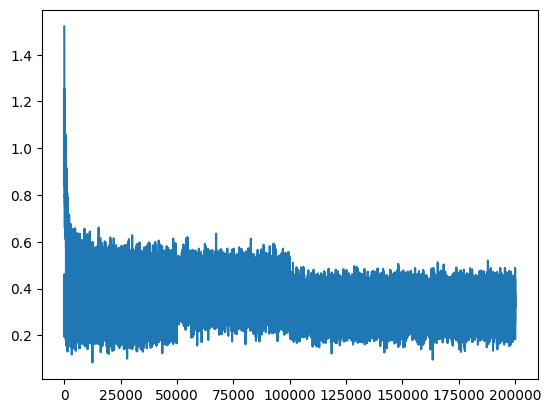

In [151]:
plt.plot(stepi, lossi)

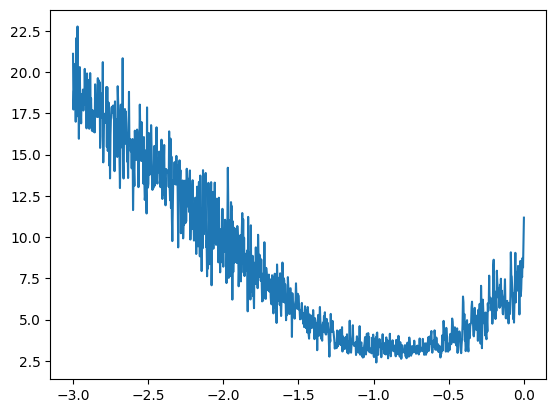

In [84]:
plt.plot(lri, lossi)

In [152]:
def get_loss(X, Y):
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 40) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    return loss

print("training loss: ", get_loss(Xtr, Ytr))
print("validation loss: ", get_loss(Xdev, Ydev))

training loss:  tensor(2.1171, grad_fn=<NllLossBackward0>)
validation loss:  tensor(2.1675, grad_fn=<NllLossBackward0>)


# training split, dev/validation split, test split
80%, 10%, 10%

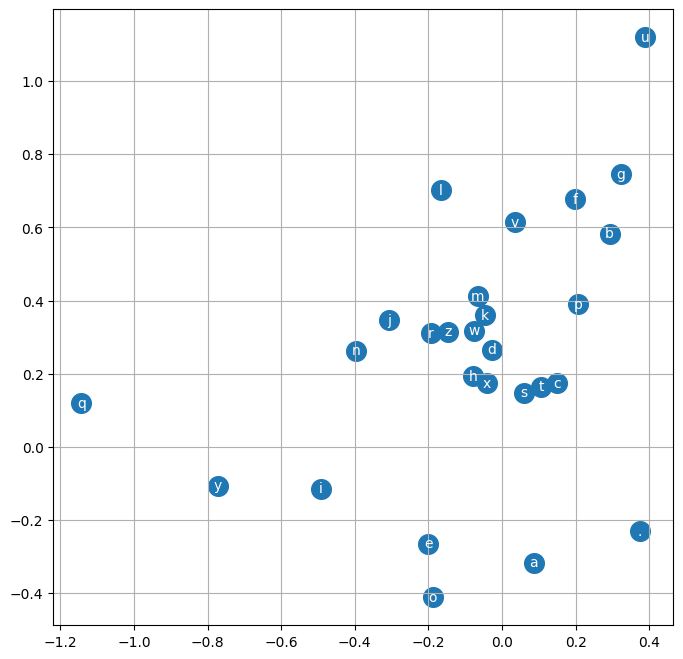

In [119]:
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

# sampling

In [155]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

mora.
kayah.
seel.
ndyn.
alarethan.
endra.
gradeerdiel.
izeli.
jenleigh.
vananar.
kayzion.
kalin.
shiber.
shiriel.
kinde.
jelienn.
pucou.
brence.
ryyleun.
elsy.
